# Class DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [27]:
import importlib
importlib.reload(dexpress)

<module 'dexpress.dexpress' from '/home/sina/projects/mop/BYVSTZP_2020/dexpress/dexpress/dexpress.py'>

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
print(isoform.shape)
print(gene.shape)

(6160, 69172)
(6160, 19190)


In [6]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [30]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

01-Nov-20 14:43:32 - 1 of 2 assignments: GABAergic
01-Nov-20 14:43:33 - 2 of 2 assignments: Glutamatergic


CPU times: user 1.65 s, sys: 1.51 s, total: 3.16 s
Wall time: 3.15 s


In [33]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

01-Nov-20 14:44:49 - 1 of 2 assignments: GABAergic
01-Nov-20 14:44:51 - 2 of 2 assignments: Glutamatergic


CPU times: user 3.91 s, sys: 4.39 s, total: 8.3 s
Wall time: 8.3 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [53]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

setdiff = np.setdiff1d(markers_isoform.name.apply(lambda x: "-".join(x.split("-")[0:-1])), markers_gene[relevant_genes].name.apply(lambda x: x.split("_")[0]))

markers_isoform = markers_isoform[markers_isoform.name.apply(lambda x: "-".join(x.split("-")[0:-1])).isin(setdiff)].sort_values(["es", "p_corr"])

In [137]:
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")

,index,name,p_raw,p_corr,es
87854,Glutamatergic,Anapc11-201_ENSMUST00000026128,0,2.22507e-308,-0.922185
23062,GABAergic,Zc3h15-201_ENSMUST00000081591,3.18128e-78,7.4601e-75,-0.673867
17824,GABAergic,Napg-201_ENSMUST00000025474,1.19731e-55,2.80769e-52,-0.5936
34740,GABAergic,Ppib-202_ENSMUST00000213785,2.79462e-54,6.55339e-51,-0.556182
30168,GABAergic,Grin2b-205_ENSMUST00000152012,4.48797e-74,1.05243e-70,-0.55132
...,...,...,...,...,...
81000,Glutamatergic,Meg3-202_ENSMUST00000126289,6.86738e-124,3.38287e-120,1.10764
123996,Glutamatergic,Srsf11-208_ENSMUST00000133090,8.08007e-140,3.98024e-136,1.11461
100376,Glutamatergic,Rab6a-203_ENSMUST00000107048,2.43492e-85,1.19944e-81,1.12926
83340,Glutamatergic,Oxr1-204_ENSMUST00000110297,4.74341e-125,2.33661e-121,1.35472


In [129]:
markers_gene[markers_gene.name.str.contains("Meg3")]

,index,name,p_raw,p_corr,es
2528,GABAergic,Meg3_ENSMUSG00000021268,0.00113451,1,-0.0610749
21718,Glutamatergic,Meg3_ENSMUSG00000021268,0.00113451,1,0.0610749


In [130]:
specific_gene = "Meg3_ENSMUSG00000021268"
specific_isoform = "Meg3-203_ENSMUST00000128178"

specific_cluster = "Glutamatergic"

In [131]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


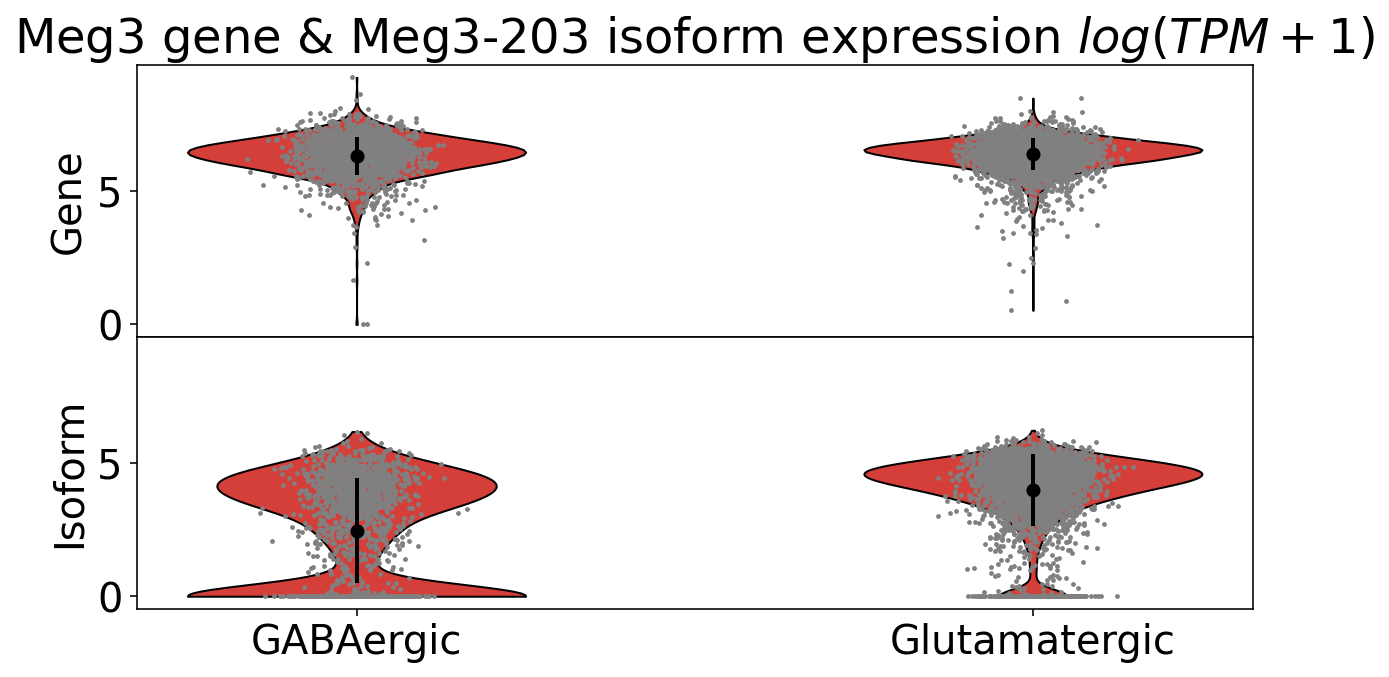

In [132]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0])

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax[0].set_ylabel("Gene")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1])
    
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=0, ha="center")
ax[1].set_ylabel("Isoform")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression $log(TPM + 1)$".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]))
#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

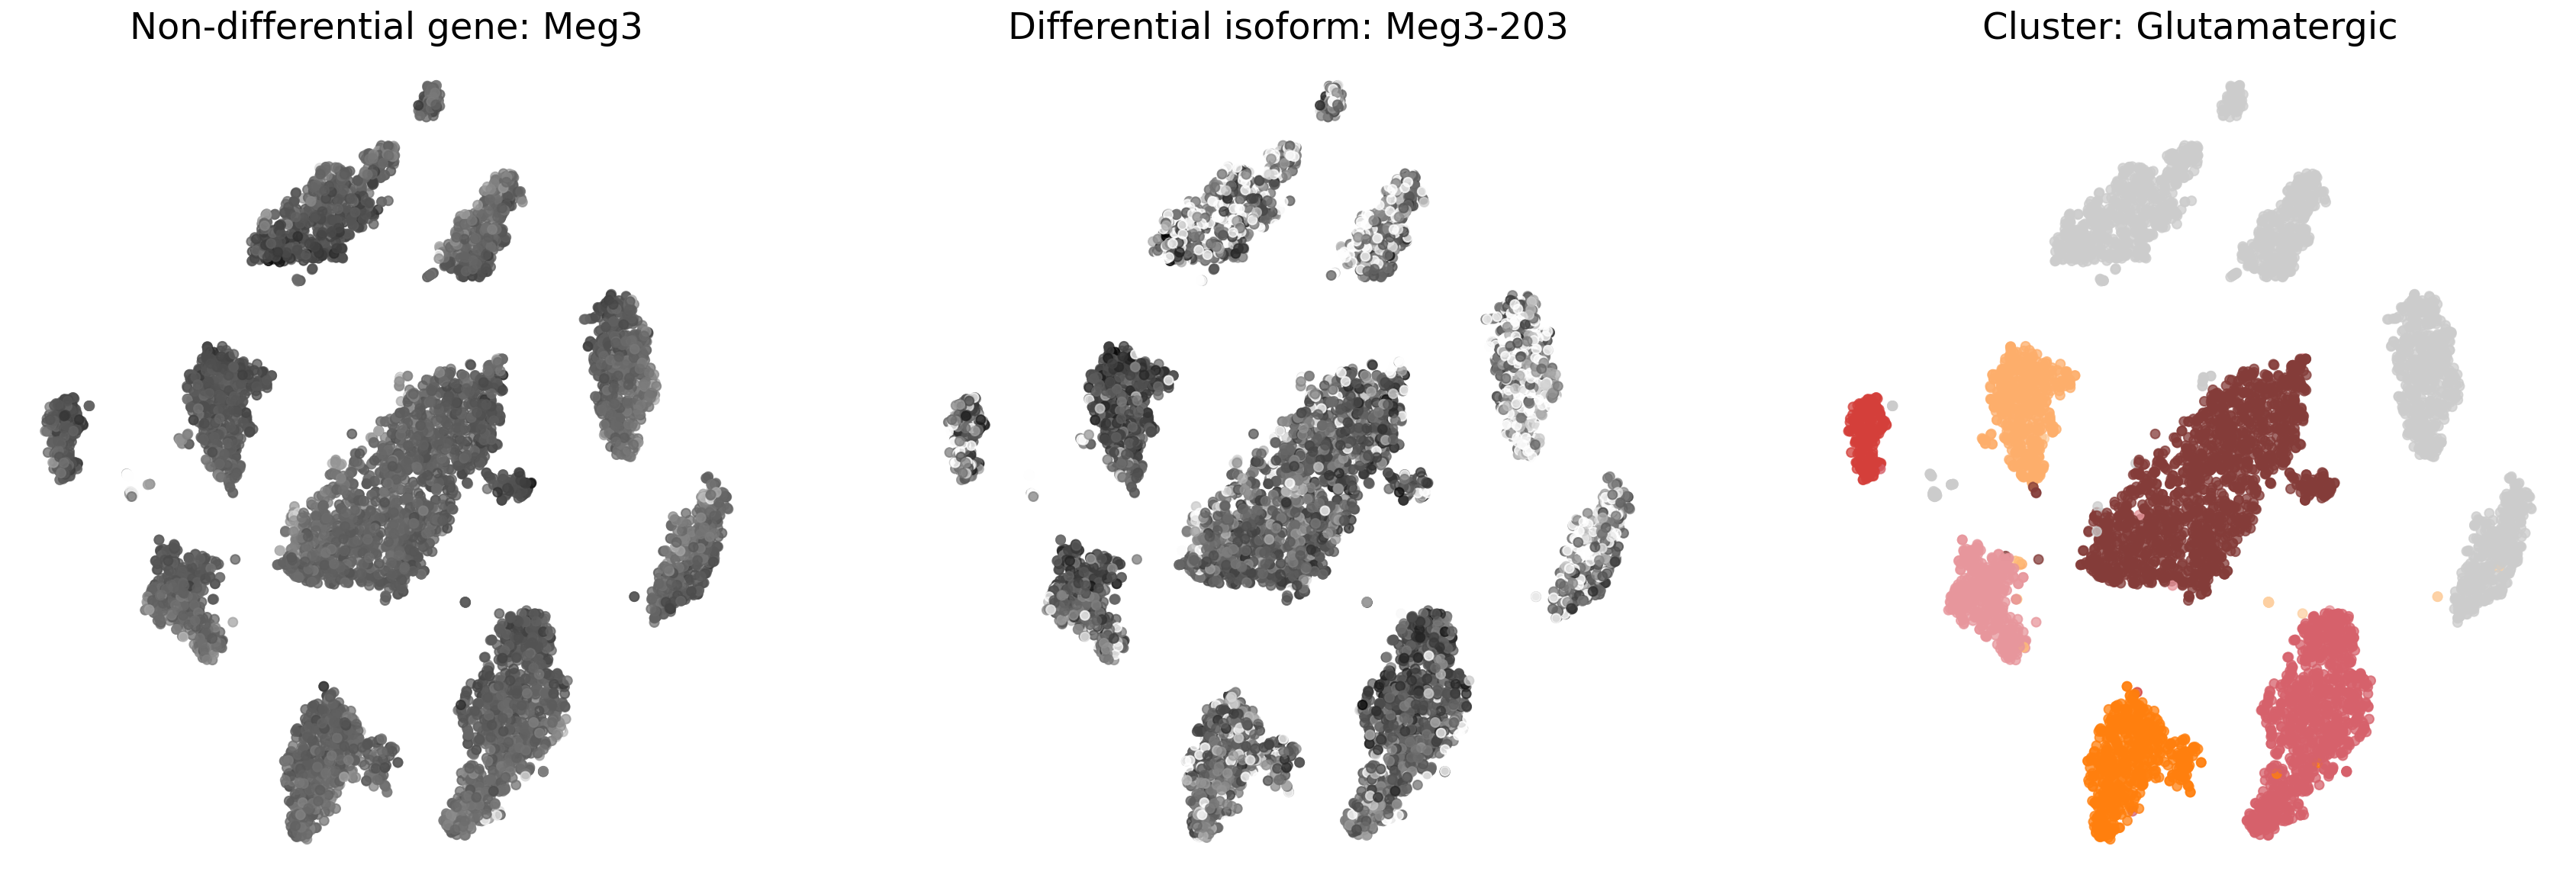

In [133]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["class_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
#plt.savefig("./figures/class_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [138]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [139]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [140]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

745 isoforms from 398 genes identified.


In [37]:
markers_isoform.to_csv("../../tables/unordered/class_DE_isoform_only.csv")

In [141]:
np.log(2)

0.6931471805599453